# VGGNet Sensie example

For the following, I collected a few hundred images of gorillas from arond the web which I haven't checked in due to copyright reasons. 

If you'd like to run this example from scratch, you can try downloading [ImageNet URLs](http://image-net.org/download-imageurls) or find another collection of the class of your choice.

In [2]:
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.applications.vgg16 as vgg16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
import random
import scipy
import pandas as pd
import numpy as np
from scipy import ndimage
import glob
from PIL import Image

import sensie

In [4]:
# Load vgg model, and get some images of gorillas

In [5]:
model, preprocess = vgg16.VGG16(), vgg16.preprocess_input

In [6]:
# Sensie instance:
probe_vgg = sensie.Probe(model)

Let's test:
-   Class
-   distance from mean colour
-   Initial dimensions of image
-   Aspect ratio of initial image

In [7]:
# Correct category for lowland gorilla
GORILLA_CAT = 366


In [8]:
# I collected some VGG gorilla pics (but didn't check them into Github...)
imagenames = glob.glob("./gorillas/*jpg")
metadata = pd.read_csv("./gorillas/img_metadata.csv") # Heights and widths
N = len(metadata)
print("Gorilla images:", N)

Gorilla images: 220


In [9]:
metadata.head(3)

,imagename,width,height
0,1067602996_3fb59504fc_o.jpg,602,800
1,107889955_eac433e46b_o.jpg,1264,1255
2,10816612864_479b8b7d29_o.jpg,4262,2841


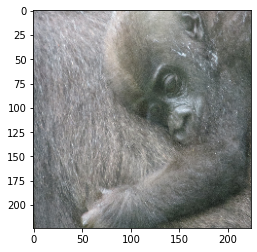

In [14]:
imagename = random.choice(imagenames)
image = load_img(imagename, target_size=(224, 224))
plt.imshow(image)
image = np.array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [15]:
yhat = model.predict(image)
cat = np.argmax(yhat)
label = decode_predictions(yhat)
label = label[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))

gorilla (93.44%)


In [16]:
X_test = np.zeros((N, 224, 224, 3))
y_test = np.array([GORILLA_CAT] * N)

In [17]:
for i, imagename in enumerate(metadata.loc[:, 'imagename']):
    image = load_img("./gorillas/" + imagename, target_size=(224, 224))
    image = np.array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image) 
    X_test[i] = image


In [18]:
# Let's prepare the quantities to test for
metadata['aspect_ratio'] = metadata['width']/metadata['height']
metadata['kilopixels'] = (metadata['width']*metadata['height']/1000).astype(int)
mean_colour = X_test.mean(axis=(0, 1, 2))
metadata['color_distance'] = np.linalg.norm(X_test.mean(axis=(1,2)) - mean_colour, ord=2, axis=1.)  # 'distances' is a list

In [19]:
sensitivity = probe_vgg.predict_and_measure(X_test, y_test, metadata, prop="aspect_ratio", 
                                            label="aspect ratio", plot=False)

[########################################] 100% (1/1)    aspect_ratio     

Text(0.5, 1.0, 'Aspect ratio vs score')

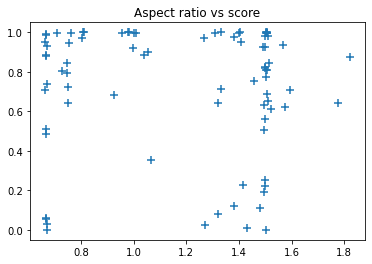

In [20]:
results = sensitivity.tests['aspect_ratio']
plt.scatter(results.p_vals, results.means, marker="+", s=50)
plt.title("Aspect ratio vs score")
# Doesn't seem very sensitive to aspect ratio!

In [21]:
def show_image(index):
    img = Image.open(metadata.iloc[index]["imagename"])
    plt.imshow(img)
    print("%.2f" % (rightscores[index]*100))

In [22]:
sensitivity = probe_vgg.predict_and_measure(X_test, y_test, 
                                            metadata[['aspect_ratio', 'color_distance', 'kilopixels']],
                                            prop=None,
                                            label="aspect ratio", plot=False)

[########################################] 100% (3/3)    kilopixels        

In [23]:
sensitivity.tests

{'aspect_ratio': <sensie.sensie.SingleTest at 0x7f82807d51d0>,
 'color_distance': <sensie.sensie.SingleTest at 0x7f82806948d0>,
 'kilopixels': <sensie.sensie.SingleTest at 0x7f8280742b50>}

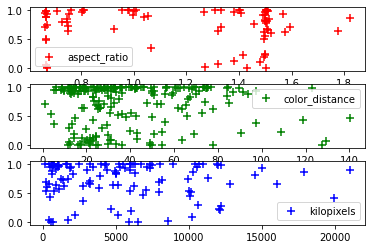

In [24]:
fig = plt.figure()
x = 0
colors = " rgb"
for name, test in sensitivity.tests.items():
    x += 1
    plt.subplot(3, 1, x)
    plt.scatter(test.p_vals, test.means, marker="+", color=colors[x], s=50, label=name)
    plt.legend()


In [29]:
# Doesn't look like any particular sensitivity to these metrics. Let's test to be sure:
colortest = sensitivity.tests['color_distance'].set_credible_interval(means_only=False)


Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 4 chains: 100%|██████████| 2400/2400 [00:03<00:00, 680.54draws/s] 
The acceptance probability does not match the target. It is 0.9364922430883004, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9383783592578735, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9475641560530997, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9222442773486889, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [27]:
sensitivity.tests['color_distance'].summary()

,sensitivity,significance,sens_50_low,sens_50_high,sens_95_low,sens_95_high
property,,,,,,
color_distance,-0.000142,low,-0.000834,0.000388,-0.001889,0.001644


Yes, zero is in the 50% credible interval. Visually:

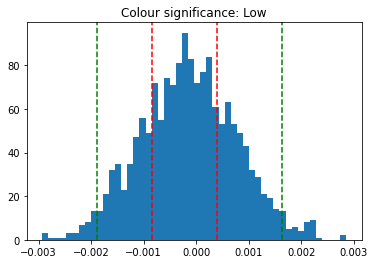

In [28]:
# As we can see it's consistent with zero.

test = sensitivity.tests['color_distance'].pos['beta']
summary = sensitivity.tests['color_distance'].summary().iloc[0]
min_, max_, mean_ = test.min(), test.max(), test.mean()
plt.hist(test, bins=50)

plt.axvline(summary.sens_50_low, ls="--", color="red")
plt.axvline(summary.sens_50_high, ls="--", color="red")
plt.axvline(summary.sens_95_low, ls="--", color="green")
plt.axvline(summary.sens_95_high, ls="--", color="green")
plt.title(f"Colour significance: Low");